In [1]:
import numpy as np
import pandas as pd

import neurodsp
from neurodsp import shape, spectral
from scipy import stats, signal
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('white')

# A. Average event-related frequencies for 4 simulated conditions

In [2]:
np.random.seed(0)
N_trials = 100
Fs = 1000
f_range = (8,12)
freq = 10

tlims = (-1, 2)
T_full = tlims[1] - tlims[0]
T_burst = tlims[1]

f_hipass_brown = 2
hipass_N = int(3 * Fs / f_hipass_brown)
if hipass_N % 2 == 0:
    hipass_N += 1
t = np.arange(tlims[0], tlims[1], 1/Fs)

conditions = ['baseline', 'faster', 'longer bursts', 'nonsinusoidal']
speed_modulate = {'baseline': 1, 'longer bursts': 1, 'faster': 1.1, 'nonsinusoidal': 1}
rdsyms = {'baseline': .5, 'longer bursts': .5, 'faster': .5, 'nonsinusoidal': .2}
prob_leave_bursts = {'baseline': .2, 'longer bursts': .1, 'faster': .2, 'nonsinusoidal': .2}
prob_enter_bursts = {'baseline': .2, 'longer bursts': .3, 'faster': .2, 'nonsinusoidal': .2}

# For each condition
xs = defaultdict(list)
dfs = defaultdict(list)
for c in conditions:
    cycle_features = {'amp_mean': 1, 'amp_burst_std': 0, 'amp_std': 0,
                      'period_mean': int(Fs / (freq*speed_modulate[c])), 'period_burst_std': 0, 'period_std': 0,
                      'rdsym_mean': rdsyms[c], 'rdsym_burst_std': 0, 'rdsym_std': 0}
    
    for tr in range(N_trials):
        # Simulate noise
        brown = neurodsp.sim_filtered_brown_noise(T_full, Fs, (f_hipass_brown, None), hipass_N)
        
        # Generate oscillator after time zero
        oscillator, df = neurodsp.sim_bursty_oscillator(freq, T_burst, Fs,
                                                        prob_enter_burst=prob_enter_bursts[c],
                                                        prob_leave_burst=prob_leave_bursts[c],
                                                        cycle_features=cycle_features,
                                                        return_cycle_df=True)
        
        # Add oscillator after time zero
        x = np.copy(brown*.5)
        x[-len(oscillator):] += 10*oscillator
        xs[c].append(x)
        dfs[c].append(df)

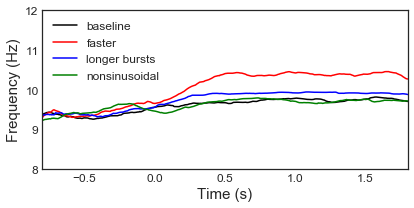

In [3]:
# Compute average event-related instantaneous frequency
freqs = defaultdict(list)
mean_freq_ts = defaultdict()
for c in conditions:
    for tr in range(N_trials):
        # Compute instantaneous frequency and median filter it as in Samaha 2015 Curr Bio
        i_f = neurodsp.freq_by_time(xs[c][tr], Fs, f_range)
        i_f2 = i_f.copy()
        for samps in np.linspace(11, 401, 10):
            samps = int(samps)
            if samps % 2 == 0:
                samps += 1
            i_f2 = signal.medfilt(i_f2, kernel_size=samps)

        freqs[c].append(i_f2)
    mean_freq_ts[c] = np.mean(np.array(freqs[c]), axis=0)

# Plot event-related instantaneous frequency
plt.figure(figsize=(6,3))
colors = ['k', 'r', 'b', 'g']
for i, c in enumerate(conditions):
    plt.plot(t, mean_freq_ts[c], label=c, color=colors[i])

plt.xlim((-.8, 1.8))
plt.ylim((8, 12))
plt.legend(loc='best', fontsize=12)
plt.xlabel('Time (s)', size=15)
plt.ylabel('Frequency (Hz)', size=15)
plt.xticks(size=12)
plt.yticks(size=12)

plt.tight_layout()
plt.savefig('figs/6A_inst_freq_ts')

# B. Average event-related cycle frequencies for 4 simulated conditions

In [4]:
bin_edges = np.arange(-.8, 2, .1)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

osc_kws = {'amplitude_fraction_threshold': 0,
           'amplitude_consistency_threshold': .6,
           'period_consistency_threshold': .75,
           'monotonicity_threshold': .8,
           'N_cycles_min': 3}

# Apply 1-50Hz bandpass filter
f_bandpass = (1, 50)
filter_seconds = (2, .2)

xs_broad = defaultdict(list)
binned_freqs = defaultdict()
dfs_shape = defaultdict(list)
for c in conditions:
    for tr in range(N_trials):
        # Do broad bandpass of signal
        x_broad = neurodsp.filter(xs[c][tr], Fs, 'highpass', f_hi=f_bandpass[0],
                                  N_seconds=filter_seconds[0],
                                  remove_edge_artifacts=False)
        x_broad = neurodsp.filter(x_broad, Fs, 'lowpass', f_lo=f_bandpass[1],
                                  N_seconds=filter_seconds[1],
                                  remove_edge_artifacts=False)
        xs_broad[c].append(x_broad)
        
        df_shape = shape.features_by_cycle(x_broad, Fs, f_range, center_extrema='T',
                                           estimate_oscillating_periods=True,
                                           estimate_oscillating_periods_kwargs=osc_kws)
        df_shape['trial'] = tr
        dfs_shape[c].append(df_shape)
        
    # Aggregate all trials
    df_shape_cond = pd.concat(dfs_shape[c]).reset_index(drop=True)[['sample_trough', 'period', 'is_cycle']]
    # Compute time from sample
    df_shape_cond['t'] = t[df_shape_cond['sample_trough'].values]
    # Bin time
    df_shape_cond['t_bin'] = pd.cut(df_shape_cond['t'], bin_edges)
    
    # Compute bursting and amp in each time bin
    df_freq_by_t = df_shape_cond[df_shape_cond['is_cycle']].groupby('t_bin')['period'].mean()
    binned_freqs[c] = Fs/df_freq_by_t.values

/Users/scott/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


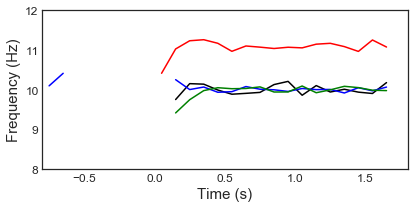

In [5]:
plt.figure(figsize=(6,3))
colors = ['k', 'r', 'b', 'g']
for i, c in enumerate(conditions):
    plt.plot(bin_centers, binned_freqs[c], color=colors[i])

plt.xlim((-.8, 1.8))
plt.ylim((8, 12))
plt.xlabel('Time (s)', size=15)
plt.ylabel('Frequency (Hz)', size=15)
plt.xticks(size=12)
plt.yticks(size=12)

plt.tight_layout()
plt.savefig('figs/6B_cycle_freq_ts')

# C,E,G. Distributions of trial instantaneous frequencies
* Recall that bandpass heavily determines what inst_freq will be when there's no oscillation

MannwhitneyuResult(statistic=1800.0, pvalue=2.6915115354444225e-15)
MannwhitneyuResult(statistic=3395.0, pvalue=4.4197852689278578e-05)
MannwhitneyuResult(statistic=4939.0, pvalue=0.4412404285538748)


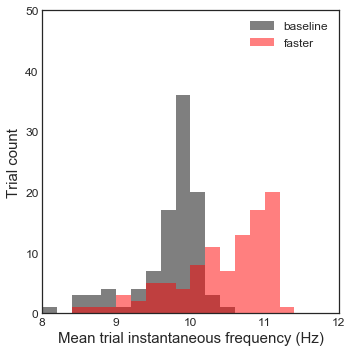

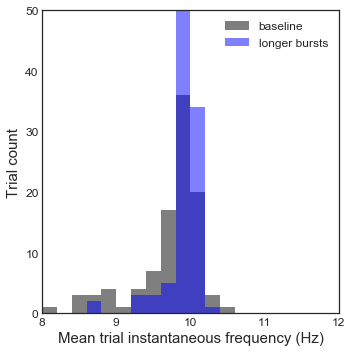

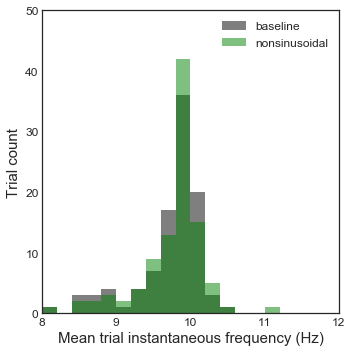

In [6]:
# Compute mean instantaneous freq 500ms to 1000ms for each condition
tlim = (.5, 1)
tidxs = np.logical_and(t>=tlim[0], t<tlim[1])
inst_freq_trial_means = {}
for c in conditions:
    inst_freq_trial_means[c] = np.mean(np.array([x[tidxs] for x in freqs[c]]), axis=1)
    
# Histogram of mean instantaneous freq to see trial differentiation
for letter, c, color in zip(['C', 'E', 'G'], [ 'faster', 'longer bursts', 'nonsinusoidal'], ['r', 'b', 'g']):
    plt.figure(figsize=(5,5))
    colors = ['k', color]
    for i, c2 in enumerate(['baseline', c]):
        plt.hist(inst_freq_trial_means[c2], bins=np.arange(8, 12, .2), label=c2, alpha=.5, color=colors[i])

    plt.xlim((8, 12))
    plt.ylim((0, 50))
    plt.legend(loc='best', fontsize=12)
    plt.ylabel('Trial count', size=15)
    plt.xlabel('Mean trial instantaneous frequency (Hz)', size=15)
    plt.xticks(np.arange(8,13), size=12)
    plt.yticks(size=12)

    plt.tight_layout()
    plt.savefig('figs/6'+ letter + '_inst_freq_dist_' + c)
    
    print(stats.mannwhitneyu(inst_freq_trial_means['baseline'], inst_freq_trial_means[c]))

# D, F, H. Distributions of trial cycle frequencies

MannwhitneyuResult(statistic=69.5, pvalue=2.1354900838045847e-16)
MannwhitneyuResult(statistic=1728.5, pvalue=0.20296416628087094)
MannwhitneyuResult(statistic=1017.0, pvalue=0.20509053530186661)


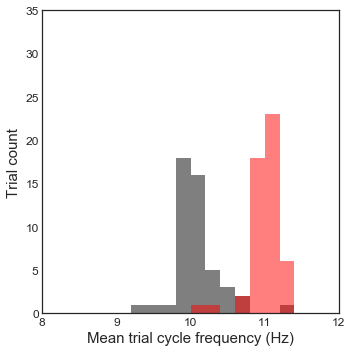

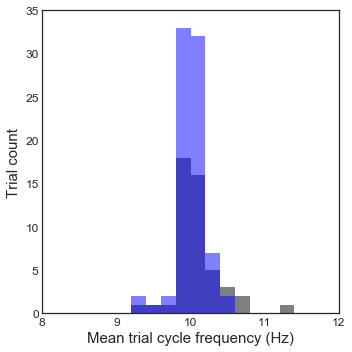

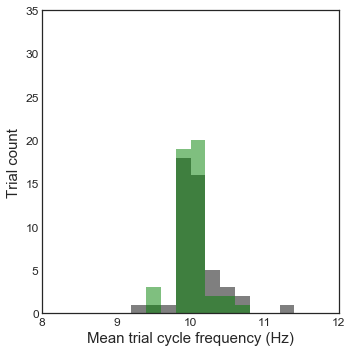

In [7]:
# Compute mean cycle freq 500ms to 1000ms for each condition
tlim = (.5, 1)
tidxs = np.logical_and(t>=tlim[0], t<tlim[1])
cycle_freq_trial_means = {}
for c in conditions:
    # Get dataframe of interest
    df_temp = pd.concat(dfs_shape[c])
    df_temp = df_temp[df_temp['is_cycle']]
    df_temp['t'] = t[df_temp['sample_trough'].values]
    df_temp = df_temp[(df_temp['t']>=tlim[0]) & (df_temp['t']<tlim[1])]
    cycle_freq_trial_means[c] = Fs/df_temp.groupby('trial')['period'].mean()
    
# Histogram of mean instantaneous freq to see trial differentiation
for letter, c, color in zip(['D', 'F', 'H'], ['faster', 'longer bursts', 'nonsinusoidal'], ['r', 'b', 'g']):
    plt.figure(figsize=(5,5))
    colors = ['k', color]
    for i, c2 in enumerate(['baseline', c]):
        plt.hist(cycle_freq_trial_means[c2], bins=np.arange(8, 12, .2), alpha=.5, color=colors[i])

    plt.xlim((8, 12))
    plt.ylim((0, 35))
    plt.ylabel('Trial count', size=15)
    plt.xlabel('Mean trial cycle frequency (Hz)', size=15)
    plt.xticks(np.arange(8,13), size=12)
    plt.yticks(size=12)

    plt.tight_layout()
    plt.savefig('figs/6'+ letter + '_cycle_amp_dist_' + c)
    
    print(stats.mannwhitneyu(cycle_freq_trial_means['baseline'], cycle_freq_trial_means[c]))